# Bayesian A/B simulation

Suppose you have N consumers in a test panel choosing between options A and B. You want to infer from this data which option is really the most popular option.

This notebook explores the following question: can we save on A/B testing by using bayesian sequential testing - and how much?

The setup is very simple:
* generate some fake A/B choice data
* form a Beta prior that describes your belief about the probability of A being the more chosen option 
* with each step of M data points, update your posterior to reflect the data
* define your desired certainty level, and calculate the highest probability density interval (HPDI) of the posterior
* if HPDI is outside the region of practical equivalence (ROPE), discontinue testing and choose the more likely alternative
* if HPDI is completely inside ROPE, discontinue test and infer that A and B are equally good

In [251]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import arviz as az
from typing import List
from collections import Counter
import pandas as pd
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from itertools import product
from tqdm import tqdm
import seaborn as sns

import sys
sys.path.append("..")
from modules.faker import create_fake_ab_test_results
from modules.utils import progress_print


## Example of one experiment

Generate fake A/B data with the faker module.

In [182]:
n_resp = 1000
prob_a = 0.6
results = create_fake_ab_test_results(n=n_resp, prob_a=prob_a)

Inspect the results

In [183]:
print(Counter(results["choice"]))
print("Percentage of A: {}".format(sum(results["choice"]==0)/len(results["choice"])))
print("Prob A was set at: {}".format(prob_a))

Counter({0: 627, 1: 373})
Percentage of A: 0.627
Prob A was set at: 0.6


In this simple case of a binary choice experiment, we can solve the posterior analytically for the seen data:


Number of 0s (A) in data: 627
Number of 0s (B) in data: 373


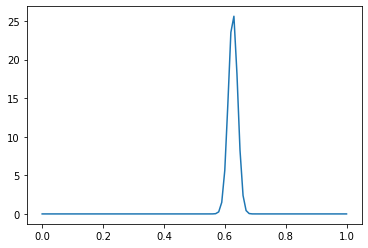

In [184]:
L = sum(results["choice"]) # number of B in data
W = len(results["choice"]) - L # number of A in data
print("Number of 0s (A) in data: {}".format(W))
print("Number of 0s (B) in data: {}".format(L))
x = jnp.linspace(0, 1, 101)
#jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x))
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))

As we can see, the posterior shows that we can be quite sure that A is the more popular option.

To make this sensitive to prior beliefs, we can set a prior that describes our prior understanding. `Beta(X,Y)` prior describes prior data where A was chosen X times and B was chosen Y times. For example, if we have very strong opinion that A and B are equally good, we could use a prior such as `Beta(1000,1000)`. On the other hand, if we are unsure and want a uncommitted prior, we can use e.g. `Beta(2,2)`. We will use a `Beta(10,10)` prior as default in the model, to reflect the understanding that differences between A and B are unlikely to be huge.

In [185]:
desired_certainty = 0.95
prior = dist.Beta(10,10)
#prior=dist.Uniform(0,1) # you could also use a flat prior, but that is quite unrealistic usually

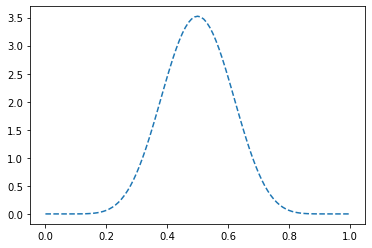

In [186]:
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(prior.log_prob(x)), "--")

As you can see, the prior `Beta(10,10)` shows that likely values are centered around 0.5, meaning A and B are equally good.

Generally, we can use the module `numpyro` to compute posteriors for our Beta model.

In [187]:
def model(W, L, prior):
    p = numpyro.sample("p", prior)  # prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

L = 4
#print("Number of 0s (A) in data: {}".format(W))
W = 6
#print("Number of 0s (B) in data: {}".format(L))
#print("Distribution of seen data:{}".format(Counter(true_results["choice"][0:i])))
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=W, L=L, prior=prior)
params, losses = svi.run(random.PRNGKey(0), 10000, progress_bar=False)

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, prob=desired_certainty, group_by_chain=False)


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         p      0.53      0.09      0.53      0.36      0.70   8788.29      1.00



Note that in this special beta-binomial case, we can also compute the posterior straight from the posterior distribution that we computed analytically!

In [188]:
s_beta = dist.Beta(W+10, L+10).sample(random.PRNGKey(1), (10000,))
print("mean {:.2f}, std {:.2f}, median {:.2f}, 2.5% {:.2f}, 97.5% {:.2f}".format(
np.mean(s_beta), np.std(s_beta), np.median(s_beta), np.percentile(s_beta, 2.5), np.percentile(s_beta, 97.5)))

mean 0.53, std 0.09, median 0.53, 2.5% 0.36, 97.5% 0.71


As we can see, results of the `numpyro` SVI computation and analytical solution are almost exactly the same (up to a certain level of randomness). Analytical solution - i.e. straight simulation from the posterior - is much faster, so we should use that whenever possible.

Now, let's define our function for analysis of the whole experiment. Inputs are:
* `desired_certainty`: level of certainty about the inference of A vs. B
* `true_results`: the results of the experiment
* `true_probs_a`: The true probability of theta for generation of the data.
* `min_n_obs`: Minimum number of observations that must be run before breaking the experiment.
* `inference_strategy`: `"analytical"` for using the analytical solution, `"svi"` for SVI. Analytical is much faster.
* `rope_width`: Radius of the ROPE region.
* `null_effect`: Value of no effect (0.5 in binary choice).
* `step`: Evaluate breaking of experiment at each `step` obs. Smaller is more accurate, but makes analysis runtime longer.

In [198]:
def sim_single_experiment(desired_certainty: float, true_results: dict, true_probs_a: List[float],
                         min_n_obs: int =10, inference_strategy:str="analytical", rope_width:float=0.01,
                         null_effect:float = 0.5, step:int=50, print_progress: str = False) -> pd.DataFrame:
    n_range = list(range(0,len(true_results["choice"])+1,step))
    n_range[0] = 1
    experiment_length = len(n_range)
    rope_area = (null_effect-rope_width, null_effect+rope_width)
    res = pd.DataFrame()
    res["hpdi_lower"] = [np.nan] * experiment_length
    res["hpdi_upper"] = [np.nan] * experiment_length
    res["n"] = [np.nan] * experiment_length
    res["percent_in_rope"] = [np.nan] * experiment_length
    res["conclusion"] = [np.nan] * experiment_length
    for true_prob_a in true_probs_a:
        progress_print("Running experiment with true_prob_a: {}, desired_certainty {}, ROPE {}\n".format(true_prob_a, 
                                                                                                desired_certainty,
                                                                                               rope_area),
                      print_progress)

        # run inference for each step
        # we do not run sequentially so we can analyse the counterfactual situation of not breaking the exp
        samples, hpdi = list(zip(*[run_inference(i, true_results, inference_strategy) for i in n_range]))
        res["hpdi_lower"] = [x[0] for x in hpdi]
        res["hpdi_upper"] = [x[1] for x in hpdi]
        res["n"] = n_range
        res.iloc[0, res.columns.get_loc("n")] = 1
        res["desired_certainty"] = desired_certainty
        res["true_prob_a"] = true_prob_a
        res["ended"] = False
        res["stopping_reason"] = None
        res["conclusion"] = None
        

        for i in range(len(res)):
            nobs = res.loc[:,"n"][i]
            if ((nobs % 10 == 0) & (nobs >= min_n_obs)):
                hpdi = (res["hpdi_lower"][i], res["hpdi_upper"][i])
                percent_in_rope = max(0, min(rope_area[1], hpdi[1]) - max(rope_area[0], hpdi[0])) / (hpdi[1]-hpdi[0])
                res["percent_in_rope"] = percent_in_rope
                progress_print("With {} obs {}, {:.0%} HPDI is {:.3f} - {:.3f} ({:.3%} in ROPE)".format(nobs, dict(Counter(true_results["choice"][0:nobs])),
                                                                              desired_certainty, hpdi[0],hpdi[1],
                                                                                                percent_in_rope), 
                               print_progress)
                rope = check_rope(percent_in_rope)
                if rope == "uncertain":
                    progress_print("Too much uncertainty at {} obs, should continue study.".format(nobs), print_progress)
                    pass
                elif rope == "no_diff":
                    progress_print("HDI inside ROPE, so no practical difference at {} certainty!".format(desired_certainty), print_progress)
                    res.loc[res["n"] >= nobs,"ended"] = True
                    res.loc[res["n"] >= nobs,"stopping_reason"] = "bayes"
                    res.loc[res["n"] == nobs,"conclusion"] = "no_diff"
                    progress_print("Breaking at {} obs.\n".format(nobs), print_progress)
                    break
                elif rope == "signif_diff":
                    progress_print("HDI outside ROPE, so signif. diff at {} certainty!".format(desired_certainty), print_progress)
                    res.loc[res["n"] >= nobs,"ended"] = True
                    res.loc[res["n"] >= nobs,"stopping_reason"] = "bayes"
                    if hpdi[0] > 0.5:
                        res.loc[res["n"] >= nobs,"conclusion"] = "A"
                        progress_print("Conclude: A is better!", print_progress)
                    elif hpdi[1] < 0.5:
                        res.loc[res["n"] >= nobs,"conclusion"] = "B"
                        progress_print("Conclude: B is better!", print_progress)
                    else:
                        #print("Something is wrong, HDI {} outside ROPE {} but unsure".format(hpdi, rope_area))
                        #res.loc[res["n"] >= nobs,"conclusion"] = "WHAT"
                        raise ValueError("Something is wrong, HDI {} outside ROPE {} but unsure".format(hpdi, rope_area))
                    progress_print("Breaking at {} obs.\n".format(nobs), print_progress)
                    break

        # if experiment didn't break prematurely, change last obs to "ended"
        if sum(res["ended"])==0:
            res.iloc[-1, res.columns.get_loc("ended")] = True
            res.iloc[-1, res.columns.get_loc("stopping_reason")] = "end_of_experiment"
            progress_print("Ending experiment at {} obs because reached end of data.".format(nobs), print_progress)

    res["correct"] = res.apply(lambda row: row["conclusion"]=="A", axis=1)
    return res

def check_rope(percent_in_rope):
    if percent_in_rope > 0.99:
        return "no_diff"
    elif percent_in_rope < 0.01:
        return "signif_diff"
    else:
        return "uncertain"

def run_inference(i, true_results, inference_strategy, prior_w=10, prior_l=10):
    W = sum(true_results["choice"][0:i]==0)
    L = sum(true_results["choice"][0:i]==1)
    if inference_strategy == "svi":
        def model(W, L):
            prior = numpyro.distributions.Beta(prior_w,prior_l)
            p = numpyro.sample("p", prior)  # prior
            numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood
        guide = AutoLaplaceApproximation(model)
        svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=W, L=L, prior=dist.Beta(1,1))
        params, losses = svi.run(random.PRNGKey(0), 1000, progress_bar=False)
        # display summary of quadratic approximation
        post_samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
    if inference_strategy == "analytical":
                post_samples = dict()
                post_samples["p"] = dist.Beta(W+prior_w, L+prior_l).sample(random.PRNGKey(1), (1000,))
    hpdi=numpyro.diagnostics.hpdi(post_samples["p"],prob=desired_certainty)
    return post_samples, hpdi

In [199]:
n_resp = 500
prob_a = 0.60
certainty_level = 0.90
results = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob_a)
res = sim_single_experiment(certainty_level, results, true_probs_a=[prob_a], step=50, print_progress=True)

Running experiment with true_prob_a: 0.6, desired_certainty 0.9, ROPE (0.49, 0.51)

With 50 obs {0: 21, 1: 29}, 90% HPDI is 0.330 - 0.561 (8.669% in ROPE)
Too much uncertainty at 50 obs, should continue study.
With 100 obs {0: 49, 1: 51}, 90% HPDI is 0.401 - 0.579 (11.201% in ROPE)
Too much uncertainty at 100 obs, should continue study.
With 150 obs {0: 78, 1: 72}, 90% HPDI is 0.444 - 0.595 (13.209% in ROPE)
Too much uncertainty at 150 obs, should continue study.
With 200 obs {0: 106, 1: 94}, 90% HPDI is 0.462 - 0.595 (15.053% in ROPE)
Too much uncertainty at 200 obs, should continue study.
With 250 obs {0: 135, 1: 115}, 90% HPDI is 0.478 - 0.598 (16.675% in ROPE)
Too much uncertainty at 250 obs, should continue study.
With 300 obs {0: 161, 1: 139}, 90% HPDI is 0.480 - 0.590 (18.161% in ROPE)
Too much uncertainty at 300 obs, should continue study.
With 350 obs {0: 188, 1: 162}, 90% HPDI is 0.485 - 0.587 (19.571% in ROPE)
Too much uncertainty at 350 obs, should continue study.
With 400 

In [200]:
res

,hpdi_lower,hpdi_upper,n,percent_in_rope,conclusion,desired_certainty,true_prob_a,ended,stopping_reason,correct
0,0.322189,0.732686,1,0.0,None,0.9,0.6,False,None,False
1,0.330025,0.560735,50,0.0,None,0.9,0.6,False,None,False
2,0.400565,0.579125,100,0.0,None,0.9,0.6,False,None,False
3,0.443730,0.595139,150,0.0,None,0.9,0.6,False,None,False
4,0.462204,0.595071,200,0.0,None,0.9,0.6,False,None,False
5,0.477863,0.597801,250,0.0,None,0.9,0.6,False,None,False
6,0.480221,0.590350,300,0.0,None,0.9,0.6,False,None,False
7,0.484933,0.587122,350,0.0,None,0.9,0.6,False,None,False
8,0.493434,0.589235,400,0.0,None,0.9,0.6,False,None,False
9,0.505927,0.597135,450,0.0,None,0.9,0.6,False,None,False


In [201]:
cutoff = (res.ended==True).idxmax()
res.iloc[(cutoff-1):(cutoff + 5)]
cutoff_n = res.loc[(res.ended==True).idxmax(),"n"]

Plot how the CI of theta has evolved over the experiment.

In [202]:
res.hvplot.line(x="n", 
                y=["hpdi_lower","hpdi_upper","true_prob_a"]) * \
    hv.HLine(0.5).opts(
    opts.HLine(color='blue', line_width=1, line_dash="dashed")) * \
    hv.VLine(cutoff_n).opts(
    opts.VLine(color="red", line_width=0.8, line_dash="dashed"))

:Overlay
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [n]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]

     n    variable     value
0    1  hpdi_lower  0.322189
1   50  hpdi_lower  0.330025
2  100  hpdi_lower  0.400565
3  150  hpdi_lower  0.443730
4  200  hpdi_lower  0.462204


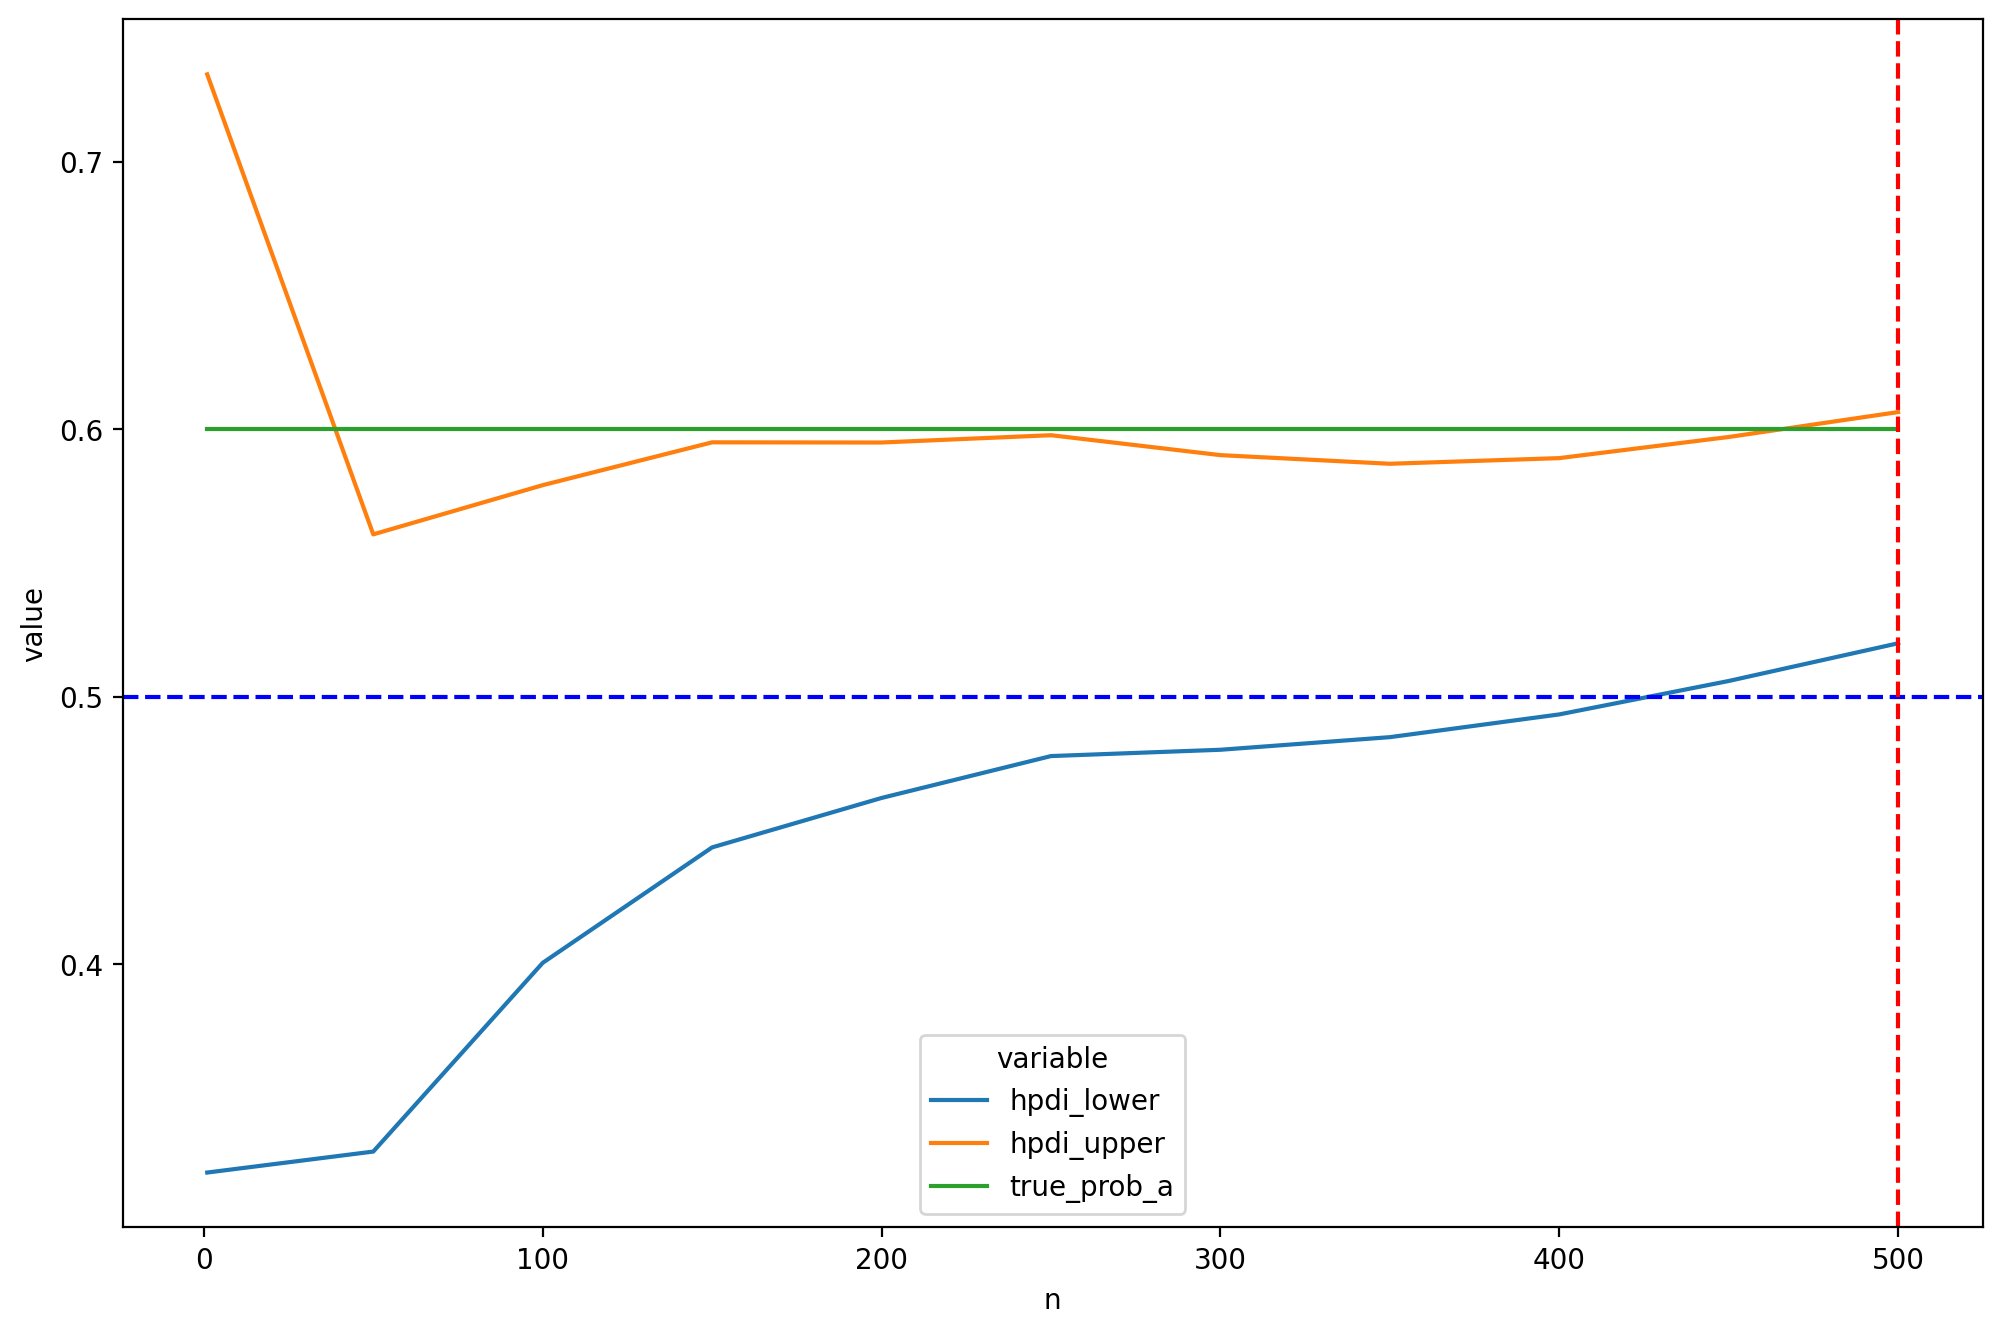

In [264]:
d = pd.melt(res, id_vars=["n"], value_vars=["hpdi_lower","hpdi_upper","true_prob_a"])
fig = sns.lineplot(data=d, x="n",y="value", hue="variable")
plt.axhline(0.5,linestyle='--', color="blue")
plt.axvline(cutoff_n, linestyle="--", color="red")
plt.show()

## Simulating several experiments

Extension of one experiment to several is simple. We just define a grid of parameters, run N experiments for each cell in grid, and collect the results to see how our bayesian system behaves at each parameter value.

In [203]:
def run_single_exp(prob, cert, experiment_no, print_graphs, print_progress):
    exp_no = "_".join([str(prob), str(cert), str(experiment_no + 1)])
    progress_print("Creating fake data for experiment {}, true_prob {}, desired cert {}, n_obs {}".format(experiment_no,
                                                                                                 prob, cert, n_resp),
         print_progress)
    sim_data = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob)
    progress_print("Simulated data has {} obs".format(Counter(sim_data["choice"])), print_progress)
    single_res = sim_single_experiment(cert, sim_data, true_probs_a=[prob], print_progress=print_progress)
    single_res["exp_no"] = exp_no
    cutoff = (single_res.ended==True).idxmax()
    cutoff_n = res.loc[(res.ended==True).idxmax(),"n"]
    
    if print_graphs:
        d = pd.melt(res, id_vars=["n"], value_vars=["hpdi_lower","hpdi_upper","true_prob_a"])
        fig = sns.lineplot(data=d, x="n",y="value", hue="variable")
        plt.axhline(0.5,linestyle='--', color="blue")
        plt.axvline(cutoff_n, linestyle="--", color="red")
        plt.show()
    return single_res

def sim_many_experiments(n_exp: int, true_probs_a: List[float], 
                         desired_cert_list: List[float], n_resp: int =500, 
                         print_graphs=False, print_progress=False) -> pd.DataFrame:
    params = list(product(true_probs_a,desired_cert_list,range(1,n_exp+1)))
    progress_print(params, print_progress)
    all_res = [None]*len(params)
    progress_print("Running total of {} experiments.".format(len(all_res)), print_progress)
    i = 1
    all_res = [run_single_exp(prob, cert, n, print_graphs, print_progress) for prob,cert,n in tqdm(params)]
    return pd.concat(all_res)

Now let us run our simulation for the parameter grid. Below you will see the defined parameters, and the setting of `max_n_resp`, describing maximum number of responses per experiment. The higher this number, the more chances our bayesian analysis has to break early and save on cost.

In [213]:
max_n_resp = 500
test_output = False
if test_output:
    all_results = sim_many_experiments(2, true_probs_a=[0.55, 0.65], desired_cert_list=[0.8, 0.9], n_resp=max_n_resp)
else:
    all_results = sim_many_experiments(1000, true_probs_a=[0.52, 0.53, 0.54, 0.55, 0.60, 0.65], 
                                       desired_cert_list=[0.8, 0.9, 0.95, 0.99], n_resp=max_n_resp)

100%|██████████| 24000/24000 [50:01<00:00,  8.00it/s] 


In [214]:
all_results

,hpdi_lower,hpdi_upper,n,percent_in_rope,conclusion,desired_certainty,true_prob_a,ended,stopping_reason,correct,exp_no
0,0.322189,0.732686,1,0.230781,None,0.80,0.52,False,None,False,0.52_0.8_2
1,0.370159,0.601848,50,0.230781,None,0.80,0.52,False,None,False,0.52_0.8_2
2,0.415704,0.594750,100,0.230781,None,0.80,0.52,False,None,False,0.52_0.8_2
3,0.428309,0.579243,150,0.230781,None,0.80,0.52,False,None,False,0.52_0.8_2
4,0.448658,0.581653,200,0.230781,None,0.80,0.52,False,None,False,0.52_0.8_2
...,...,...,...,...,...,...,...,...,...,...,...
6,0.595800,0.701322,300,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_1001
7,0.587560,0.686428,350,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_1001
8,0.591327,0.684032,400,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_1001
9,0.596613,0.684050,450,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_1001


Make a DF that describes the result of each experiment at when it ended (whether due to bayesian cutoff or end of data).

In [215]:
all_results.loc[all_results.stopping_reason=="end_of_experiment","conclusion"] = "uncertain"

In [216]:
cutoff_results = all_results[all_results["ended"]==True].dropna(axis=0, how="any").groupby("exp_no").head(1)

In [217]:
cutoff_results

,hpdi_lower,hpdi_upper,n,percent_in_rope,conclusion,desired_certainty,true_prob_a,ended,stopping_reason,correct,exp_no
10,0.480517,0.567179,500,0.230781,uncertain,0.80,0.52,True,end_of_experiment,False,0.52_0.8_2
10,0.476741,0.563523,500,0.230464,uncertain,0.80,0.52,True,end_of_experiment,False,0.52_0.8_3
10,0.457433,0.544127,500,0.230695,uncertain,0.80,0.52,True,end_of_experiment,False,0.52_0.8_4
10,0.452812,0.539512,500,0.230680,uncertain,0.80,0.52,True,end_of_experiment,False,0.52_0.8_5
10,0.447237,0.533660,500,0.231418,uncertain,0.80,0.52,True,end_of_experiment,False,0.52_0.8_6
...,...,...,...,...,...,...,...,...,...,...,...
2,0.515391,0.690877,100,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_997
2,0.548221,0.720304,100,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_998
4,0.518349,0.649751,200,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_999
2,0.548221,0.720304,100,0.000000,A,0.99,0.65,True,bayes,True,0.65_0.99_1000


In [218]:
cutoff_results.groupby(["desired_certainty","true_prob_a"])["conclusion"].value_counts(dropna=False)

desired_certainty  true_prob_a  conclusion
0.80               0.52         uncertain      825
                                A              169
                                B                6
                   0.53         uncertain      677
                                A              322
                                B                1
                   0.54         uncertain      579
                                A              418
                                B                3
                   0.55         A              565
                                uncertain      435
                   0.60         A              992
                                uncertain        8
                   0.65         A             1000
0.90               0.52         uncertain      829
                                A              166
                                B                5
                   0.53         uncertain      693
                                A      

In [219]:
del all_results

In [220]:
for cert in sorted(cutoff_results.desired_certainty.unique()):
    display(cutoff_results[cutoff_results.desired_certainty == cert].groupby(["desired_certainty","true_prob_a"])["conclusion"].value_counts(dropna=False).reset_index(name="values").\
        pivot(index=["desired_certainty","true_prob_a"], columns=["conclusion"],values="values").reset_index().\
        hvplot(kind="bar", x="true_prob_a", y=["A","B","uncertain"], 
               stacked=True, subplots=False, rot=90, title="Certainty: {}".format(str(cert))))


:Bars   [true_prob_a,Variable]   (value)

:Bars   [true_prob_a,Variable]   (value)

:Bars   [true_prob_a,Variable]   (value)

:Bars   [true_prob_a,Variable]   (value)

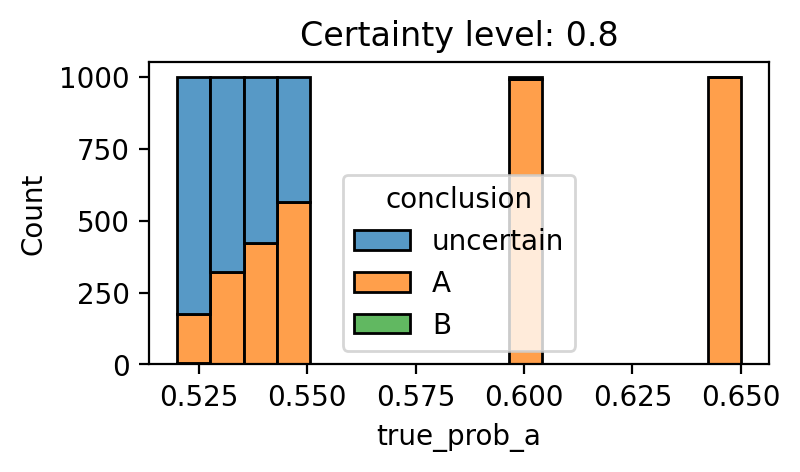

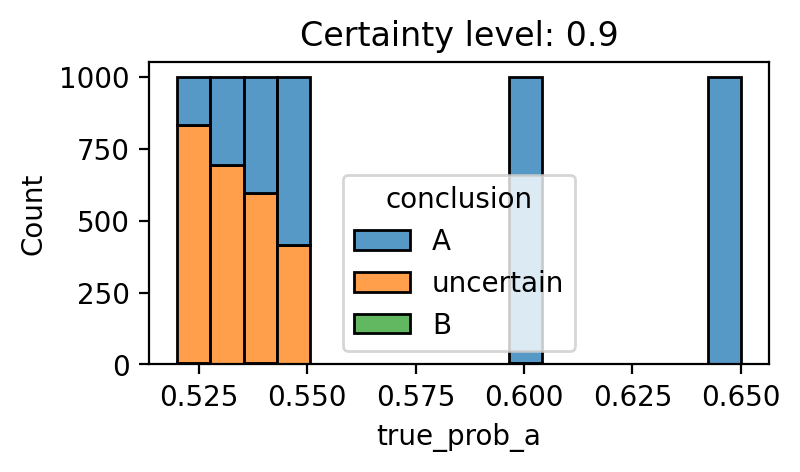

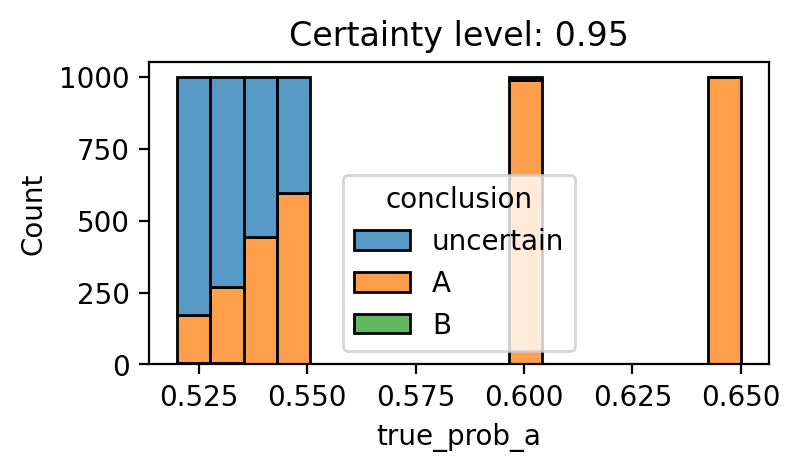

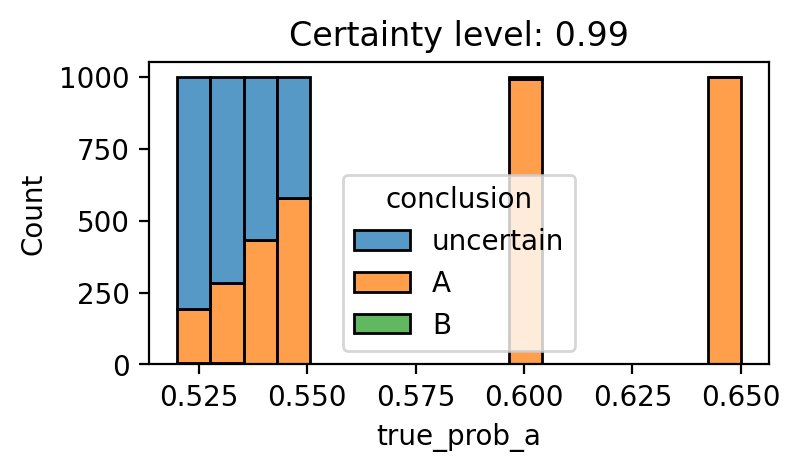

In [375]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 4,2
for cert in sorted(cutoff_results.desired_certainty.unique()):
    
    d = cutoff_results[cutoff_results.desired_certainty == cert].\
        loc[:,["true_prob_a","conclusion"]]
        #   id_vars=["true_prob_a"], value_vars=["A","B","uncertain"]).fillna(0)
    #display(d)
    
    sns.histplot(data=d, x="true_prob_a",hue="conclusion",multiple="stack")
    plt.title("Certainty level: {}".format(cert))
    plt.show()

The bars show us immediately a clear trend: as true probability increases, the number of `uncertain` conclusions decreases. This is intuitive - the stronger the true preference for A, the easier it is to detect with a fixed N of data.

What about mistakes? Leaving out the uncertain conclusions, how often does our system make an erroneous bayesian inference?

true_prob_a,0.52,0.53,0.54,0.55,0.60,0.65
desired_certainty,,,,,,
0.99,0.973958,0.978799,0.997696,1.000000,1.0,1.0
0.95,0.965318,0.977612,1.000000,0.996639,1.0,1.0
0.90,0.970760,1.000000,0.990172,0.998294,1.0,1.0
0.80,0.965714,0.996904,0.992874,1.000000,1.0,1.0


<AxesSubplot:xlabel='true_prob_a', ylabel='desired_certainty'>

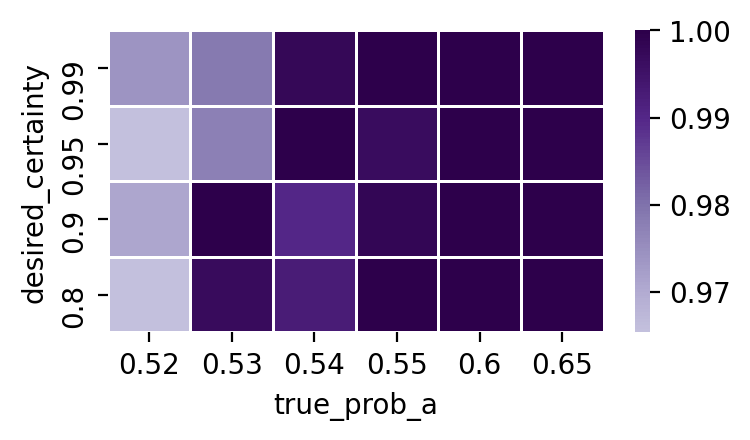

In [376]:
d = cutoff_results[cutoff_results.conclusion != "uncertain"].groupby(["desired_certainty","true_prob_a"])["correct"].value_counts(dropna=False, normalize=True).reset_index(name="value").fillna(0)
d=d.loc[d.correct==True,["desired_certainty","true_prob_a","value"]]\
    .pivot("desired_certainty","true_prob_a","value").sort_values("desired_certainty",ascending=False)
display(d.head(10))
sns.heatmap(d, linewidths=0.5, cmap="PuOr", center=0.95)

In the figure above, we see that all versions of the model are over 97% accurate, and if true probability is over 55% then they are perfectly accurate.

To make a business decision on whether and how to use the system, we can analyse the impact on costs. This analysis assumes a fixed cost per response, and a very high cost on an erroneous inference between A and B. Naturally, such costs differ between use cases, and should preferably be elicited either from historical records or SMEs.

In [377]:
cost_per_response = 1
cost_of_wrong_ab_decision = 10**6 # million
print("Cost per response {}, cost of wrong A/B decision {}\n".format(cost_per_response, cost_of_wrong_ab_decision))
params = set(zip(cutoff_results.desired_certainty.values, cutoff_results.true_prob_a.values))
params = list(sorted(params))
#print(list(sorted(params)))

cost_outcome_df = pd.DataFrame(params)#.pivot(index=0, columns=1, values=2)
cost_outcome_df.columns = ["desired_certainty","true_prob_a"]
cost_outcome_df[["saved_sampling","wrong_decisions","cost_wrong_decisions","mistake_prob","total"]] = np.nan

for cert, true_prob in params:
    print("For certainty {}, prob_a {} we got:".format(cert, true_prob))
    d = cutoff_results.loc[(cutoff_results.desired_certainty == cert) & (cutoff_results.true_prob_a == true_prob) & \
                          (cutoff_results.conclusion != "uncertain")]
    uncertain_results = len(cutoff_results.loc[(cutoff_results.desired_certainty == cert) & (cutoff_results.true_prob_a == true_prob) & \
                          (cutoff_results.conclusion == "uncertain")])
    
    max_sample = max_n_resp
    saved_in_sampling = sum([max_sample-x for x in d.n])
    n_wrong_decisions = sum(d.correct == False)
    correct_decisions = sum(d.correct == True)
    wrong_decision_cost = cost_of_wrong_ab_decision * n_wrong_decisions
    mistake_prob = (n_wrong_decisions) / (len(d) + uncertain_results)
    print("Saved money in sampling {:d} (max sample {})".format(saved_in_sampling, max_sample))
    print("Lost in wrong_decisions {:d}, probability of mistake {:.2%}".format(wrong_decision_cost, mistake_prob))
    print("Total {:+d}\n".format(saved_in_sampling - wrong_decision_cost))
    
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob), 
                        "saved_sampling"]=saved_in_sampling
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob), 
                        "uncertain_results"]=uncertain_results
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "wrong_decisions"]=n_wrong_decisions
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "correct_decisions"]=correct_decisions
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "cost_wrong_decisions"]=wrong_decision_cost
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "mistake_prob"]=mistake_prob
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "total"] = saved_in_sampling - wrong_decision_cost
    cost_outcome_df.loc[(cost_outcome_df.desired_certainty == cert) & (cost_outcome_df.true_prob_a == true_prob),
                        "save_per_exp"] = (saved_in_sampling - wrong_decision_cost) / len(d)
    
    cost_outcome_df = cost_outcome_df[["desired_certainty","true_prob_a","uncertain_results", "correct_decisions",
                              "wrong_decisions","saved_sampling","cost_wrong_decisions","mistake_prob",
                              "total","save_per_exp"]]

Cost per response 1, cost of wrong A/B decision 1000000

For certainty 0.8, prob_a 0.52 we got:
Saved money in sampling 43750 (max sample 500)
Lost in wrong_decisions 6000000, probability of mistake 0.60%
Total -5956250

For certainty 0.8, prob_a 0.53 we got:
Saved money in sampling 74850 (max sample 500)
Lost in wrong_decisions 1000000, probability of mistake 0.10%
Total -925150

For certainty 0.8, prob_a 0.54 we got:
Saved money in sampling 97550 (max sample 500)
Lost in wrong_decisions 3000000, probability of mistake 0.30%
Total -2902450

For certainty 0.8, prob_a 0.55 we got:
Saved money in sampling 132650 (max sample 500)
Lost in wrong_decisions 0, probability of mistake 0.00%
Total +132650

For certainty 0.8, prob_a 0.6 we got:
Saved money in sampling 334900 (max sample 500)
Lost in wrong_decisions 0, probability of mistake 0.00%
Total +334900

For certainty 0.8, prob_a 0.65 we got:
Saved money in sampling 405450 (max sample 500)
Lost in wrong_decisions 0, probability of mistake 

In [378]:
display(cost_outcome_df)

,desired_certainty,true_prob_a,uncertain_results,correct_decisions,wrong_decisions,saved_sampling,cost_wrong_decisions,mistake_prob,total,save_per_exp
0,0.80,0.52,825.0,169.0,6.0,43750.0,6000000.0,0.006,-5956250.0,-34035.714286
1,0.80,0.53,677.0,322.0,1.0,74850.0,1000000.0,0.001,-925150.0,-2864.241486
2,0.80,0.54,579.0,418.0,3.0,97550.0,3000000.0,0.003,-2902450.0,-6894.180523
3,0.80,0.55,435.0,565.0,0.0,132650.0,0.0,0.000,132650.0,234.778761
4,0.80,0.60,8.0,992.0,0.0,334900.0,0.0,0.000,334900.0,337.600806
5,0.80,0.65,0.0,1000.0,0.0,405450.0,0.0,0.000,405450.0,405.450000
6,0.90,0.52,829.0,166.0,5.0,43950.0,5000000.0,0.005,-4956050.0,-28982.748538
7,0.90,0.53,693.0,307.0,0.0,69600.0,0.0,0.000,69600.0,226.710098
8,0.90,0.54,593.0,403.0,4.0,100150.0,4000000.0,0.004,-3899850.0,-9581.941032
9,0.90,0.55,414.0,585.0,1.0,136450.0,1000000.0,0.001,-863550.0,-1473.634812


What do the numbers tell us? Well, for example with a true difference of 0.55 and certainty level 0.99, we would expect almost 250 euros benefit per each test that was run. For 1000 tests, such a model broke early 993 times, was uncertain 7 times and made an incorrect inference 0 times!

<AxesSubplot:xlabel='true_prob_a', ylabel='desired_certainty'>

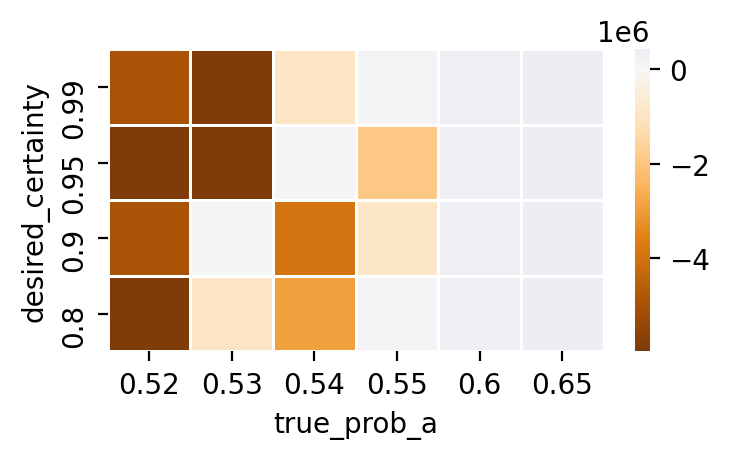

In [379]:
sns.heatmap(cost_outcome_df.pivot("desired_certainty","true_prob_a","total").\
            sort_values("desired_certainty",ascending=False),
            linewidths=0.5, cmap="PuOr",center=0)

This last figure plots average cost/saving per experiment according to true probability of A being better, for various certainty levels. What becomes clear is that the system saves costs when A is in prior probable to be better.

/Users/tjpajala/anaconda3/envs/rethink/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,desired_certainty,true_prob_a,variable,value
0,0.8,0.52,log_save_per_exp,-10.435166
1,0.8,0.53,log_save_per_exp,-7.960059
2,0.8,0.54,log_save_per_exp,-8.838433
3,0.8,0.55,log_save_per_exp,5.458644
4,0.8,0.60,log_save_per_exp,5.821864


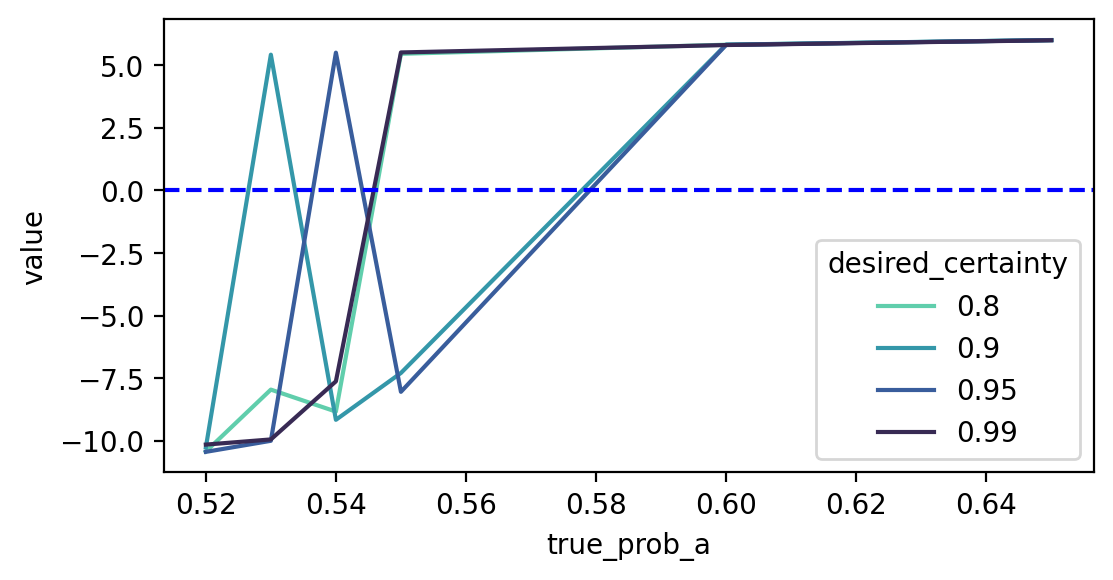

In [380]:
symlog_costs=cost_outcome_df[["desired_certainty","true_prob_a","total","save_per_exp"]]

def f_symlog(x):
    if -1 > x > 1:
        return x
    elif x>1:
        return np.log(x)
    elif x<-1:
        return -np.log(-x)

symlog_costs.loc[:,["log_total"]] = symlog_costs.total.apply(f_symlog)
symlog_costs.loc[:,["log_save_per_exp"]] = symlog_costs.save_per_exp.apply(f_symlog)

d = pd.melt(symlog_costs, id_vars=["desired_certainty","true_prob_a"],value_vars="log_save_per_exp")
display(d.head(5))
rcParams['figure.figsize'] = 6,3
palette = sns.color_palette("mako_r", d.desired_certainty.nunique())
g_results=sns.lineplot(data=d, x="true_prob_a",y="value",hue="desired_certainty", palette=palette)
#g_results.set(yscale='log')
plt.axhline(0, linestyle="--", color="blue")
#g_results.set(xticks=sample_count)
#g_results.set(xticklabels=sample_count)

Based on the cost and benefit analysis, using the bayesian model makes sense if the true probability is at least 55%. When the true probability is less, then the system makes mistakes in inference, resulting in big losses as per the assumed large cost of erroneous inference.